In [ ]:
pip install --upgrade sympy

In [ ]:
!pip install ultralytics

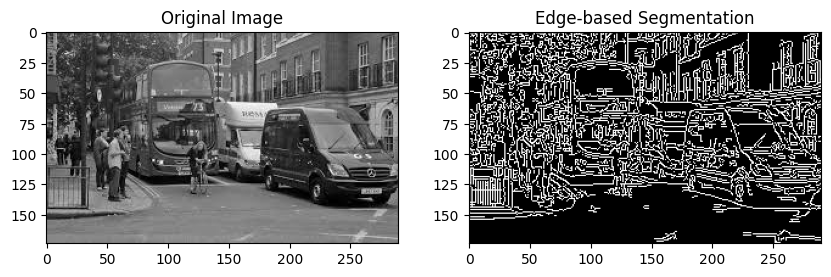

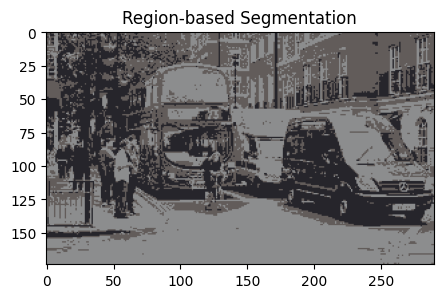

Error: Could not load image from /content/line.jpg. Please check the file path and ensure the image exists.


100%|██████████| 6.25M/6.25M [00:00<00:00, 316MB/s]

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()




image 1/1 /content/dd.jpeg: 384x640 5 persons, 1 car, 2 buss, 304.0ms
Speed: 14.6ms preprocess, 304.0ms inference, 30.5ms postprocess per image at shape (1, 3, 384, 640)


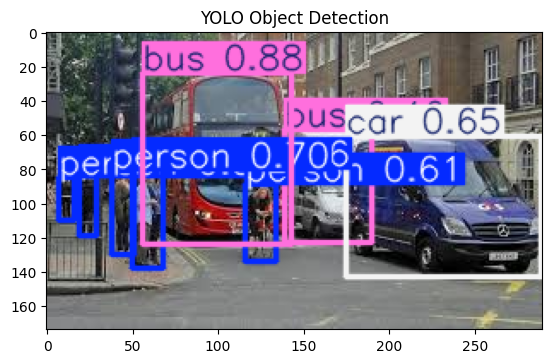

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 136MB/s]


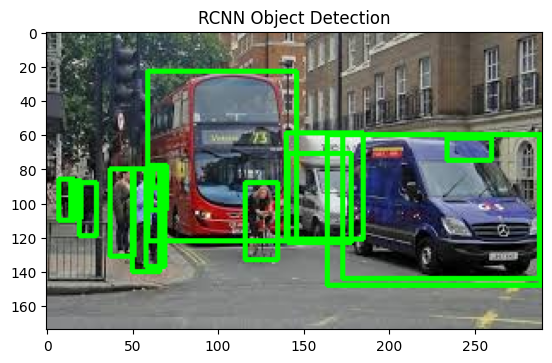

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

def edge_based_segmentation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge-based Segmentation')
    plt.show()
    return edges

def region_based_segmentation(image_path, k=3):
    image = cv2.imread(image_path)
    pixel_values = image.reshape((-1, 3)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()].reshape(image.shape)

    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title('Region-based Segmentation')
    plt.show()

def hough_transform(image_path):
    image = cv2.imread(image_path)

    # Check if image loading was successful
    if image is None:
        print(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 68, minLineLength=15, maxLineGap=250)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(10,5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Hough Transform for Line Detection')
    plt.show()

def yolo_object_detection(image_path):
    model = YOLO('yolov8n.pt')  # Load YOLOv8 model
    results = model(image_path, show=True)
    plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
    plt.title('YOLO Object Detection')
    plt.show()

def rcnn_object_detection(image_path):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image_tensor)

    boxes = outputs[0]['boxes'].numpy()
    scores = outputs[0]['scores'].numpy()
    image_cv = cv2.imread(image_path)

    for i in range(len(boxes)):
        if scores[i] > 0.5:
            x1, y1, x2, y2 = map(int, boxes[i])
            cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('RCNN Object Detection')
    plt.show()

# Example usage
image_path = '/content/dd.jpeg'  # Provide an image with lines and circles
edge_based_segmentation(image_path)
region_based_segmentation(image_path)
hough_transform("/content/line.jpg") # Updated file path
yolo_object_detection(image_path)
rcnn_object_detection(image_path)

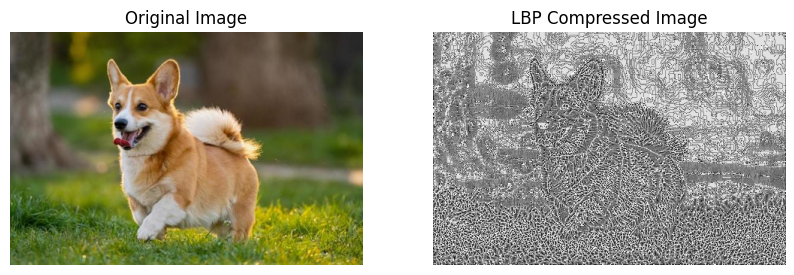

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

def lbp_compression(image_path, radius=1, points=8, compression_level=2):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale


    lbp_image = local_binary_pattern(image, points, radius, method="uniform")


    lbp_image = ((lbp_image / lbp_image.max()) * 255).astype(np.uint8)


    compressed_lbp = (lbp_image // compression_level) * compression_level


    compressed_lbp_rgb = cv2.cvtColor(compressed_lbp, cv2.COLOR_GRAY2BGR)

    return compressed_lbp_rgb

image_path = "/content/Screenshot 2025-03-17 092746.png"
compressed_image = lbp_compression(image_path)
original = cv2.imread(image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB))
plt.title('LBP Compressed Image')
plt.axis('off')

plt.show()